In [1]:
!nvidia-smi

Thu Jan 21 00:04:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/My Drive/AOI') #切換該目錄
os.listdir() #確認目錄內容

['test_images.zip',
 'classify',
 'Model.h5',
 'test_images',
 'csv',
 'QC_Sampling.ipynb',
 'QC_Diff_of_Predictions.ipynb',
 'TL_VGG16',
 'Model.ipynb',
 'QC_toCSV.ipynb',
 'TL_InceptionV3',
 'TL_ResNet50',
 'VGG16.ipynb',
 'VGG16-valAcc9683.h5',
 'ResNet50.h5',
 'image_compare.ipynb',
 'Model_Predict.ipynb',
 'InceptionV3.h5',
 'InceptionV3.ipynb',
 'ResNet50.ipynb']

In [4]:
# input 為 灰階 256 * 256 圖像
# 灰階 為 1 通道
input_shape = (256, 256, 3)

In [5]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [6]:
# 資料路徑
DATASET_PATH  = 'classify'

# 影像大小
IMAGE_SIZE = (256,256)

# 影像類別數
NUM_CLASSES = 6

BATCH_SIZE = 16

# 凍結網路層數
FREEZE_LAYERS = 2

NUM_EPOCHS = 500

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'ResNet50.h5'

In [7]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    width_shift_range=1.0,
    height_shift_range=1.0,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split = 0.2
)
train_batches = train_datagen.flow_from_directory(
    DATASET_PATH,                                             
    target_size=IMAGE_SIZE,
    interpolation='bicubic',
    class_mode='categorical',                                                  
    batch_size=BATCH_SIZE,
    subset='training'
)

valid_datagen = ImageDataGenerator()
valid_batches = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    interpolation='bicubic',
    class_mode='categorical',                                                  
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 4047 images belonging to 6 classes.
Found 1009 images belonging to 6 classes.


In [8]:
# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 輸出整個網路結構
net_final.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

In [9]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [10]:
from datetime import datetime

model_dir = os.path.join(
    'TL_ResNet50',
    datetime.now().strftime('%y%m%d_%H%M')
)
os.makedirs(model_dir, exist_ok=True)

dir_weights = os.path.join(model_dir, 'weights')
os.makedirs(dir_weights, exist_ok=True)

In [11]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# ModelCheckpoint
cp_filepath = os.path.join(dir_weights, 'ep_{epoch:02d}_ls_{val_categorical_accuracy:.2f}.h5')
cp = ModelCheckpoint(
    cp_filepath,
    monitor='val_categorical_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

# CSVLogger
csv_filepath = os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

# EarlyStopping
estop = EarlyStopping(
    monitor='val_categorical_accuracy',
    # min_delta=0.0001,
    patience=32, 
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [12]:
# 訓練模型
history = net_final.fit_generator(
  train_batches,
  steps_per_epoch = train_batches.samples // BATCH_SIZE,
  validation_data = valid_batches,
  validation_steps = valid_batches.samples // BATCH_SIZE,
  epochs = NUM_EPOCHS,
  callbacks = [cp, csv, estop]
)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
252/252 [==============================] - 1578s 6s/step - loss: 1.3276 - categorical_accuracy: 0.6345 - val_loss: 50.5624 - val_categorical_accuracy: 0.1944

Epoch 00001: val_categorical_accuracy improved from -inf to 0.19444, saving model to TL_ResNet50/210121_0005/weights/ep_01_ls_0.19.h5
Epoch 2/500
252/252 [==============================] - 97s 383ms/step - loss: 0.3285 - categorical_accuracy: 0.8891 - val_loss: 136.2991 - val_categorical_accuracy: 0.1944

Epoch 00002: val_categorical_accuracy did not improve from 0.19444
Epoch 3/500
252/252 [==============================] - 95s 378ms/step - loss: 0.2161 - categorical_accuracy: 0.9270 - val_loss: 88.2825 - val_categorical_accuracy: 0.1687

Epoch 00003: val_categorical_accuracy did not improve from 0.19444
Epoch 4/500
252/252 [==============================] - 96s 380ms/step - loss: 0.1554 - categorical_accuracy: 0.9476 - val_loss: 1.0995 - val_categorical_accuracy: 0.7966

Epoch 00004: val_categorical_accuracy improve

In [13]:
loss, accuracy = net_final.evaluate_generator(valid_batches)
print(f'loss = {loss:.2f}')
print(f'accuracy = {accuracy:.2f}')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss = 0.09
accuracy = 0.99


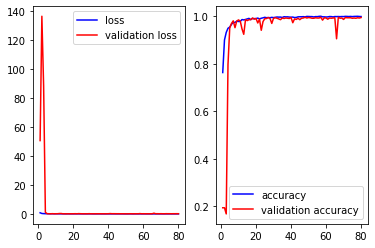

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
acc = history.history['categorical_accuracy']
epochs = range(1, len(loss)+1)
val_loss = history.history['val_loss']
val_acc = history.history['val_categorical_accuracy']

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(epochs, loss, 'b', label='loss')
ax[0].plot(epochs, val_loss, 'r', label='validation loss')
ax[0].legend()
ax[1].plot(epochs, acc, 'b', label='accuracy')
ax[1].plot(epochs, val_acc, 'r', label='validation accuracy')
ax[1].legend()
plt.show()

In [15]:
valid_datagen = ImageDataGenerator(
    rescale=1./255
    # preprocessing_function=preprocess_input
)

evaluate_itr = valid_datagen.flow_from_directory(
    './classify',
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

loss, accuracy = net_final.evaluate_generator(evaluate_itr)
print(f'loss = {loss:.2f}')
print(f'accuracy = {accuracy:.2f}')

Found 5056 images belonging to 6 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss = 0.02
accuracy = 1.00


In [16]:
import numpy as np

# labels
labels = evaluate_itr.class_indices

# then use predict_geneorator to predict the result base on model
evaluate_itr.reset()
pred = net_final.predict_generator(evaluate_itr, verbose=1)

# prediction from model
predicted_class_indices = np.argmax(pred, axis=1)
# real results in training set
true_label= evaluate_itr.classes

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


79/79 [==============================] - 22s 270ms/step


In [17]:
#使用pd.crosstab来简单画出混淆矩阵
import pandas as pd

table = pd.crosstab(predicted_class_indices, true_label,colnames=['predict'], rownames=['label'])
table

predict,0,1,2,3,4,5
label,,,,,,
0,1347,0,0,0,0,0
1,0,982,0,0,0,0
2,1,0,200,0,0,0
3,0,1,0,756,4,0
4,0,0,0,0,476,0
5,0,1,0,0,0,1288
